In [ ]:
from modules.plotter import print_result

In [ ]:
# Copyright 2024 European Space Agency
#
# This file is shipped via the optimize.esa.int web framework.
#
# This Source Code Form is subject to the terms of the Mozilla
# Public License v. 2.0. Obtain one at http://mozilla.org/MPL/2.0/.
#
# Usage example:
# x = numpy.random.uniform(-1, 1, 22)
# score = udp.fitness(x)

import heyoka as hy
import numpy as np
import scipy
import PIL
import time

from matplotlib import pyplot as plt
import matplotlib.cm as cm


def propagate_formation(dx0, stm):
    """From some initial (relative) position and velocities returns new (relative) positions at
    some future time (defined by the stm).
    Args:
        dx0 (`np.array` (N, 6)): initial relative positions and velocities.
        stm (`np.array` (6,6)): the state transition matrix at some future time.
    Returns:
        np.array (N,3): propagated positions
    """
    dxT = stm @ dx0.T
    # We return only the positions
    return dxT.T[:, :3]


def stm_factory(ic, T, mu, M, verbose=True):
    """Constructs all the STMS and reference trajectory in a CR3BP dynamics
    Args:
        ic (`np.array` (N, 6)): initial conditions (absolute).
        T (`float`): propagation time
        mu (`float`): gravity parameter
        M (`int`): number of grid points (observations)
        verbose (boolean): print time it took to build Taylor integrator and STMs
    Returns:
        (ref_state (M, 6), stms (M,6,6)): the propagated state and stms
    """
    # ----- We assemble the CR3BP equation of motion --------
    # The state
    x, y, z, vx, vy, vz = hy.make_vars("x", "y", "z", "vx", "vy", "vz")
    xarr = np.array([x, y, z, vx, vy, vz])
    # The dynamics
    r_1 = hy.sqrt((x + hy.par[0]) ** 2 + y**2 + z**2)
    r_2 = hy.sqrt((x - (1 - hy.par[0])) ** 2 + y**2 + z**2)
    dxdt = vx
    dydt = vy
    dzdt = vz
    dvxdt = (
        2 * vy
        + x
        - (1 - hy.par[0]) * (x + hy.par[0]) / (r_1**3)
        - hy.par[0] * (x + hy.par[0] - 1) / (r_2**3)
    )
    dvydt = -2 * vx + y - (1 - hy.par[0]) * y / (r_1**3) - hy.par[0] * y / (r_2**3)
    dvzdt = -(1 - hy.par[0]) / (r_1**3) * z - hy.par[0] / (r_2**3) * z
    # This array contains the expressions (r.h.s.) of our dynamics
    farr = np.array([dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt])

    # We now compute the variational equations
    # 1 - Define the symbols
    symbols_phi = []
    for i in range(6):
        for j in range(6):
            # Here we define the symbol for the variations
            symbols_phi.append("phi_" + str(i) + str(j))
    phi = np.array(hy.make_vars(*symbols_phi)).reshape((6, 6))

    # 2 - Compute the gradient
    dfdx = []
    for i in range(6):
        for j in range(6):
            dfdx.append(hy.diff(farr[i], xarr[j]))
    dfdx = np.array(dfdx).reshape((6, 6))

    # 3 - Assemble the expressions for the r.h.s. of the variational equations
    dphidt = dfdx @ phi

    dyn = []
    for state, rhs in zip(xarr, farr):
        dyn.append((state, rhs))
    for state, rhs in zip(phi.reshape((36,)), dphidt.reshape((36,))):
        dyn.append((state, rhs))

    # These are the initial conditions on the variational equations (the identity matrix)
    ic_var = np.eye(6).reshape((36,)).tolist()

    start_time = time.time()
    ta = hy.taylor_adaptive(
        # The ODEs.
        dyn,
        # The initial conditions (do not matter, they will change)
        [0.1] * 6 + ic_var,
        # Operate below machine precision
        # and in high-accuracy mode.
        tol=1e-16,
    )
    if verbose:
        print(
            "--- %s seconds --- to build the Taylor integrator -- (do this only once)"
            % (time.time() - start_time)
        )
    # We set the Taylor integration param
    ta.pars[:] = [mu]
    # We set the ic
    ta.state[:6] = ic
    ta.state[6:] = ic_var
    ta.time = 0.0
    # The time grid
    t_grid = np.linspace(0, T, M)
    # We integrate
    start_time = time.time()
    sol = ta.propagate_grid(t_grid)
    if verbose:
        print("--- %s seconds --- to construct all stms" % (time.time() - start_time))

    ref_state = sol[4][:, :6]
    stms = sol[4][:, 6:].reshape(M, 6, 6)
    return (ref_state, stms)


class orbital_golomb_array:
    def __init__(
        self,
        n_sat: int,
        ic: list,
        T: float,
        n_meas=3,
        mu=0.01215058560962404,
        scaling_factor=1e-4,
        inflation_factor=1.5,
        grid_size=20,
        verbose = True
    ):
        """Constructs a UDP (User Defined Problem) compatible with pagmo/pygmo and representing the design
        of a ballistic formation flight around a nominal CR3BP trajectory, able to perform a good interferometric
        reconstruction of the image contained in *img_path*.
        Args:
            n_sat (`int`): Number of satellites in the formation.
            ic (`list`): Initial conditions of the reference CR3BP solution.
            T (`float`): Time of flight for the measurments
            mu (`float`): parameter of the CR3BP
            n_meas (`int`): Number of interferometric measurments performed along the trajectory
                           (assumed at equally spaced time intervals).
            scaling_factor (`float`, optional): The initial positions and velocities will be scaled down by this factor.
                             Defaults to 1e-4.
            inflation_factor (`float`, optional): The allowed formation inflation. (outside this radius satellites are no longer considered)
            grid_size (int, optional): Size of the Golomb grid.
            verbose (boolean): print time it took to build Taylor integrator and STMs
        """
        # Init data members
        self.n_sat = n_sat
        self.ic = ic
        self.T = T
        self.n_meas = n_meas
        self.scaling_factor = scaling_factor
        self.grid_size = grid_size
        self.mu = mu
        self.inflation_factor = inflation_factor
        self.verbose = verbose

        # We construct the various STMs and reference trajectory
        self.ref_state, self.stms = stm_factory(ic, T, mu, n_meas, self.verbose)


    # Mandatory method in the UDP pygmo interface
    # (returns the lower and upper bound of each component in the chromosome)
    def get_bounds(self):
        return ([-1.0] * self.n_sat * 3 + [-10.0] * self.n_sat * 3 , [1.0] * self.n_sat * 3 + [10.0] * self.n_sat * 3 )

    def get_nix(self):
        """
        Get number of integer variables in the chromosome/decision vector.

        Returns:
            int: number of integer variables.
        """
        # the chromosome exists solely of float variables.
        return 0

    # Mandatory method in the UDP pygmo interface
    # (returns the fitness of the chromosome [obj1, obj2 ..., ec1, ec2, ...,iec1, iec2...]
    def fitness(self, x):
        return self.fitness_impl(x)

    # Plots the representation of the chromosome in several graphs
    def plot(self, x, figsize=(15, 10)):
        return self.fitness_impl(x, plotting=True, figsize=figsize)

    def plot_simulated_reconstruction(
        self, x, M=100, grid_size=256, image_path="data/nebula.jpg"
    ):
        """_summary_

        Args:
            x (`list` of length N): Chromosome contains initial relative positions and velocities of each satellite:
            Example: x = [ dx0_N1, dx0_N2, ..., dx0_NN, dy0_N1, dy0_N2, ..., dy0_NN , ...... , dvz0_N1, dvz0_N2, ..., dvz0_NN]
            M (`int`): Number of interferometric measurments performed along the trajectory
                           (assumed at equally spaced time intervals).
            grid_size (int, optional): _description_. Defaults to 256.
            image_path (str, optional): _description_. Defaults to "data/nebula.jpg".
        """        

        #  Time of flight for the measurments
        T = self.T

        _, stms = stm_factory(self.ic, T, self.mu, M, self.verbose)

        # 1) Decode the chromosomes into (x, y, z, vx, vy, vz) of the satellites.
        N = self.n_sat

        dx0 = np.array(
            [(i, j, k, l, m, n) for (i, j, k, l, m, n) in zip(x[      : N], 
                                                              x[N     : 2 * N], 
                                                              x[2 * N : 3 * N],
                                                              x[3 * N : 4 * N],
                                                              x[4 * N : 5 * N],
                                                              x[5 * N : ],
                                                              )]
        )


        # We now propagate all these relative positions to the measurment points. We do this accounting for the formation size
        rel_pos = []
        for stm in stms:
            # We scale the initial positions and velocities
            d_ic = dx0 * self.scaling_factor
            fc = propagate_formation(d_ic, stm)
            # We store the relative positions in the original 'units'
            rel_pos.append(fc / self.scaling_factor)
        rel_pos = np.array(rel_pos)

        # For each observation point we construct the corresponding Golomb Array
        gs_xy = []  # This will contain all the Golomb Arrays at each observation point
        g_xy = np.zeros(
            (grid_size, grid_size)
        )  # This will contain all the positions cumulatively (for plotting)

        # For each observation point we construct the corresponding Golomb Array
        gs_xz = []  # This will contain all the Golomb Arrays at each observation point
        g_xz = np.zeros(
            (grid_size, grid_size)
        )  # This will contain all the positions cumulatively (for plotting)

        # For each observation point we construct the corresponding Golomb Array
        gs_yz = []  # This will contain all the Golomb Arrays at each observation point
        g_yz = np.zeros(
            (grid_size, grid_size)
        )  # This will contain all the positions cumulatively (for plotting)

        for k in range(M):

            gs_xy.append(np.zeros((grid_size, grid_size)))
            gs_xz.append(np.zeros((grid_size, grid_size)))
            gs_yz.append(np.zeros((grid_size, grid_size)))

            points_3D = rel_pos[k]                
            # Account for an added factor allowing the formation to spread.
            points_3D = points_3D / (self.inflation_factor) 

            # and removing the points outside [-1,1] (cropping wavelengths here)
            points_3D = points_3D[np.max(points_3D, axis=1) < 1 ]
            points_3D = points_3D[np.min(points_3D, axis=1) > -1]

            # Interpret now the 3D positions [-1,1] as points on a grid.
            pos3D = (points_3D * grid_size / 2).astype(int)
            pos3D = pos3D + int(grid_size / 2)
            

            for i, j, k_ in pos3D:
                gs_xy[k][i, j] = 1
                g_xy[i, j] = 1

                gs_xz[k][i, k_] = 1
                g_xz[i, k_] = 1

                gs_yz[k][j, k_] = 1
                g_yz[j, k_] = 1

        def plot_recon(gs, g):
            # We Simulate the interferometric measurement
            otf = np.zeros((grid_size * 2 - 1, grid_size * 2 - 1))
            for one_g in gs:
                tmp = scipy.signal.correlate(one_g, one_g, mode="full")
                otf = otf + tmp
            otf[abs(otf) < 0.1] = 0
            otf[abs(otf) > 1] = 1
            otf = np.fft.fftshift(otf)

            I_o = PIL.Image.open(image_path)
            I_o = np.asarray(I_o.resize((511, 511)))
            imo_fft = np.fft.fft2(I_o)
            imr_fft = imo_fft * otf  # Hadamard product here
            I_r = abs(np.fft.ifft2(imr_fft))

            # We plot
            fig = plt.figure(figsize=(15, 3))
            ax = fig.subplots(1, 4)
            ax[0].imshow(I_o, cmap="gray")
            ax[0].axis("off")
            ax[0].set_title("Image")
            ax[1].imshow(I_r, cmap="gray")
            ax[1].axis("off")
            ax[1].set_title("Reconstruction")
            ax[2].imshow(g, cmap="gray")
            ax[2].axis("off")
            ax[2].set_title("Golomb Array Traj")
            ax[3].imshow(otf, cmap="gray")
            ax[3].axis("off")
            ax[3].set_title("Optical Transfer Function")
            plt.show()

        print('XY')
        plot_recon(gs_xy, g_xy)
        print('XZ')
        plot_recon(gs_xz, g_xz)
        print('YZ')
        plot_recon(gs_yz, g_yz)


    # Here is where the action takes place
    def fitness_impl(self, x, plotting=False, figsize=(15, 10)):
        """ Fitness function

        Args:
            x (`list` of length N): Chromosome contains initial relative positions and velocities of each satellite:
            Example: x = [ dx0_N1, dx0_N2, ..., dx0_NN, dy0_N1, dy0_N2, ..., dy0_NN , ...... , dvz0_N1, dvz0_N2, ..., dvz0_NN]
            plotting (bool, optional): Plot satellites on grid at each measurement and corresponding auto-correlation function and fill factors. Defaults to False.
            figsize (tuple, optional): Figure size. Defaults to (15, 10).
        Returns:
            float: fitness of corresponding chromosome x.
        """        
        # 1) Decode the chromosomes into (x, y, z, vx, vy, vz) of the satellites.
        N = self.n_sat

        dx0 = np.array(
            [(i, j, k, l, m, n) for (i, j, k, l, m, n) in zip(x[      : N], 
                                                              x[N     : 2 * N], 
                                                              x[2 * N : 3 * N],
                                                              x[3 * N : 4 * N],
                                                              x[4 * N : 5 * N],
                                                              x[5 * N : ],
                                                              )]
        )

        # 2) We now propagate all these relative positions to the measurment points. We do this accounting for the formation size
        rel_pos = []
        for stm in self.stms:
            # We scale the initial positions and velocities
            d_ic = dx0 * self.scaling_factor
            fc = propagate_formation(d_ic, stm)
            # We store the relative positions in the original 'units'
            rel_pos.append(fc / self.scaling_factor)
        rel_pos = np.array(rel_pos)

        # 3) At each observation epoch we compute the fill factor
        # See:
        # Memarsadeghi, Nargess, Ryan D. Joseph, John C. Kaufmann, and Byung Suk Lee.
        # "Golomb Patterns, Astrophysics, and Citizen Science Games." IEEE Access 10 (2022): 76125-76135.

        fill_factor = []

        if plotting:
            fig = plt.figure(figsize=figsize)
            gs = fig.add_gridspec(2, self.n_meas * 3, hspace=0.02, wspace=0.02)
            fig.suptitle('Placement of satellites (red squares) with respect to mothership (M)\nAutocorrelation matrix and corresponding fill factors.', fontsize=16, fontweight='bold', y=1.05)
            plt.axis("off")
            axs = gs.subplots(sharex=False, sharey=False)
            axs = axs.ravel()

        for k in range(self.n_meas):

            points_3D = rel_pos[k]   
            # Account for an added factor allowing the formation to spread. (Except for first observation, k == 0)
            if k != 0:
                points_3D = points_3D / (self.inflation_factor) 

            # and removing the points outside [-1,1] (cropping wavelengths here)
            points_3D = points_3D[np.max(points_3D, axis=1) < 1 ]
            points_3D = points_3D[np.min(points_3D, axis=1) > -1]

            # Interpret now the 3D positions [-1,1] as points on a grid.
            pos3D = (points_3D * self.grid_size / 2)
            pos3D = pos3D + int(self.grid_size / 2)
            pos3D = pos3D.astype(int)

            # Compute uv plane fill factor
            # Here we use the (https://stackoverflow.com/questions/62026550/why-does-scipy-signal-correlate2d-use-such-an-inefficient-algorithm)
            # correlate and ot correlate2d. We must then consider a threshold to define zero as the frequency domain inversion has numerical roundoffs

            I = np.zeros((self.grid_size, self.grid_size, self.grid_size))
            for i, j, k_ in pos3D:
                I[i, j, k_] = 1

            xy = np.max(I, axis = (2,))
            xz = np.max(I, axis = (1,))
            yz = np.max(I, axis = (0,))

            xyC = scipy.signal.correlate(xy, xy, mode="full")
            xzC = scipy.signal.correlate(xz, xz, mode="full")
            yzC = scipy.signal.correlate(yz, yz, mode="full")
            xyC[abs(xyC < 1e-8)] = 0
            xzC[abs(xzC < 1e-8)] = 0
            yzC[abs(yzC < 1e-8)] = 0

            f1 = np.count_nonzero(xyC) / xyC.shape[0] / xyC.shape[1]
            f2 = np.count_nonzero(xzC) / xzC.shape[0] / xzC.shape[1]
            f3 = np.count_nonzero(yzC) / yzC.shape[0] / yzC.shape[1]
            
            fill_factor.append(f1+f2+f3) # Save sum of three fill factors at this observation

            if plotting:
                # XY
                # On the first row we plot the Golomb Grids
                axs[k * self.n_meas].imshow(xy, cmap=cm.jet, interpolation="nearest", origin='lower')
                axs[k * self.n_meas].add_patch(plt.Rectangle((int(self.grid_size / 2)-0.5, int(self.grid_size / 2)-0.5), 1, 1, color='black', alpha=0.5))
                axs[k * self.n_meas].text( int(self.grid_size / 2), int(self.grid_size / 2), 'M', color='white', fontsize=12, ha='center', va='center')
                axs[k * self.n_meas].grid(False)
                axs[k * self.n_meas].set_xlim(-0.5, self.grid_size - 0.5)
                axs[k * self.n_meas].set_ylim(-0.5, self.grid_size - 0.5)
                axs[k * self.n_meas].axis("off")
                if k == 0:
                    axs[k * self.n_meas].set_title(f"1st measurement\nt = 0\nXY plane\n{int(np.sum(xy))} satellites remaining !", color="black")
                elif k == 1:
                    axs[k * self.n_meas].set_title(f"2nd measurement\nt = 1 period\nXY plane\n{int(np.sum(xy))} satellites remaining !", color="black")
                else:
                    axs[k * self.n_meas].set_title(f"3rd measurement\nt = 2 periods\nXY plane\n{int(np.sum(xy))} satellites remaining !", color="black")


                # On the second row we plot the autocorrelated Golomb Grids
                axs[k * self.n_meas + 3 * self.n_meas].imshow(xyC, cmap=cm.jet, interpolation="nearest", origin='lower')
                axs[k * self.n_meas + 3 * self.n_meas].grid(False)
                axs[k * self.n_meas + 3 * self.n_meas].axis("off")
                if k == 0:
                    axs[k * self.n_meas + 3 * self.n_meas].set_title(f"fill factor = {f1:1.6f}", color="red")
                elif k == 1:
                    axs[k * self.n_meas + 3 * self.n_meas].set_title(f"fill factor = {f1:1.6f}", color="red")
                else:
                    axs[k * self.n_meas + 3 * self.n_meas].set_title(f"fill factor = {f1:1.6f}", color="red")

                # XZ
                # On the first row we plot the Golomb Grids
                axs[k * self.n_meas + 1].imshow(xz, cmap=cm.jet, interpolation="nearest", origin='lower')
                axs[k * self.n_meas + 1].add_patch(plt.Rectangle((int(self.grid_size / 2)-0.5, int(self.grid_size / 2)-0.5), 1, 1, color='black', alpha=0.5))
                axs[k * self.n_meas + 1].text( int(self.grid_size / 2), int(self.grid_size / 2), 'M', color='white', fontsize=12, ha='center', va='center')
                axs[k * self.n_meas + 1].grid(False)
                axs[k * self.n_meas + 1].set_xlim(-0.5, self.grid_size - 0.5)
                axs[k * self.n_meas + 1].set_ylim(-0.5, self.grid_size - 0.5)
                axs[k * self.n_meas + 1].axis("off")
                if k == 0:
                    axs[k * self.n_meas + 1].set_title(f"1st measurement\nt = 0\nXZ plane\n{int(np.sum(xz))} satellites remaining !", color="black")
                elif k == 1:
                    axs[k * self.n_meas + 1].set_title(f"2nd measurement\nt = 1 period\nXZ plane\n{int(np.sum(xz))} satellites remaining !", color="black")
                else:
                    axs[k * self.n_meas + 1].set_title(f"3rd measurement\nt = 2 periods\nXZ plane\n{int(np.sum(xz))} satellites remaining !", color="black")

                # On the secnd raw we plot the autocorrelated Golomb Grids
                axs[k * self.n_meas + 1 + 3 * self.n_meas].imshow(xzC, cmap=cm.jet, interpolation="nearest", origin='lower')
                axs[k * self.n_meas + 1 + 3 * self.n_meas].grid(False)
                axs[k * self.n_meas + 1 + 3 * self.n_meas].axis("off")
                if k == 0:
                    axs[k * self.n_meas + 1 + 3 * self.n_meas].set_title(f"fill factor = {f2:1.6f}", color="red")
                elif k == 1:
                    axs[k * self.n_meas + 1 + 3 * self.n_meas].set_title(f"fill factor = {f2:1.6f}", color="red")
                else:
                    axs[k * self.n_meas + 1 + 3 * self.n_meas].set_title(f"fill factor = {f2:1.6f}", color="red")

                # XZ
                # On the first raw we plot the Golomb Grids
                axs[k * self.n_meas + 2].imshow(yz, cmap=cm.jet, interpolation="nearest", origin='lower')
                axs[k * self.n_meas + 2].add_patch(plt.Rectangle((int(self.grid_size / 2)-0.5, int(self.grid_size / 2)-0.5), 1, 1, color='black', alpha=0.5))
                axs[k * self.n_meas + 2].text( int(self.grid_size / 2), int(self.grid_size / 2), 'M', color='white', fontsize=12, ha='center', va='center')
                axs[k * self.n_meas + 2].grid(False)
                axs[k * self.n_meas + 2].set_xlim(-0.5, self.grid_size - 0.5)
                axs[k * self.n_meas + 2].set_ylim(-0.5, self.grid_size - 0.5)
                axs[k * self.n_meas + 2].axis("off")

                if k == 0:
                    axs[k * self.n_meas + 2].set_title(f"1st measurement\nt = 0\nYZ plane\n{int(np.sum(yz))} satellites remaining !", color="black")
                elif k == 1:
                    axs[k * self.n_meas + 2].set_title(f"2nd measurement\nt = 1 period\nYZ plane\n{int(np.sum(yz))} satellites remaining !", color="black")
                else:
                    axs[k * self.n_meas + 2].set_title(f"3rd measurement\nt = 2 periods\nYZ plane\n{int(np.sum(yz))} satellites remaining !", color="black")

                # On the secnd raw we plot the autocorrelated Golomb Grids
                axs[k * self.n_meas + 2 + 3 * self.n_meas].imshow(yzC, cmap=cm.jet, interpolation="nearest", origin='lower')
                axs[k * self.n_meas + 2 + 3 * self.n_meas].grid(False)
                axs[k * self.n_meas + 2 + 3 * self.n_meas].axis("off")
                if k == 0:
                    axs[k * self.n_meas + 2 + 3 * self.n_meas].set_title(f"fill factor = {f3:1.6f}", color="red")
                elif k == 1:
                    axs[k * self.n_meas + 2 + 3 * self.n_meas].set_title(f"fill factor = {f3:1.6f}", color="red")
                else:
                    axs[k * self.n_meas + 2 + 3 * self.n_meas].set_title(f"fill factor = {f3:1.6f}", color="red")
                    
                return fill_factor  # Restituisce l'elenco di tutti i fill factor


############### SIMPLE problem configuration

# DRO
ic = [0.896508460944940632764, 0., 0., 0.000000000000013951082, 0.474817948848534454598, 0.]
period = 2.6905181697222775
# Number of satellites
N = 5

# Grid size
grid_size = 11

############### Constants
# Number of observations
M = 3
T = period*(M-1) # This makes it so that each observation is made after each period

mu = 0.01215058560962404  # M_L/(M_T + M_L)

scaling_factor = 1e-4

inflation_factor = 1.23
###############

# Instantiate UDP
udp = orbital_golomb_array(n_sat=N, ic = ic, T = T, grid_size=grid_size, scaling_factor = scaling_factor, n_meas=M, inflation_factor = inflation_factor, mu=mu, verbose=False)

gen	nevals	avg         	std        	min        	max
0  	100   	-0.000136054	0.000952381	-0.00680272	-0 
1  	78    	-0.000748299	0.0021285  	-0.00680272	-0 
2  	77    	-0.00272109 	0.00333264 	-0.00680272	-0 
3  	79    	-0.00489796 	0.00305441 	-0.00680272	-0 
4  	73    	-0.00632653 	0.00173569 	-0.00680272	-0 
5  	82    	-0.00673469 	0.000676862	-0.00680272	-0 
6  	74    	-0.00680272 	0          	-0.00680272	-0.00680272
7  	74    	-0.00707483 	0.00190476 	-0.0204082 	-0.00680272
8  	85    	-0.00748299 	0.00296524 	-0.0204082 	-0.00680272
9  	78    	-0.00870748 	0.00472091 	-0.0204082 	-0.00680272
10 	83    	-0.010068   	0.00581065 	-0.0204082 	-0.00680272
11 	84    	-0.0141497  	0.00678092 	-0.0204082 	-0.00680272
12 	83    	-0.0176871  	0.00544218 	-0.0204082 	-0.00680272
13 	80    	-0.0202721  	0.00135372 	-0.0204082 	-0.00680272
14 	84    	-0.0204082  	3.46945e-18	-0.0204082 	-0.0204082 
15 	80    	-0.0204082  	3.46945e-18	-0.0204082 	-0.0204082 
16 	77    	-0.0197279  	0.00296524 	

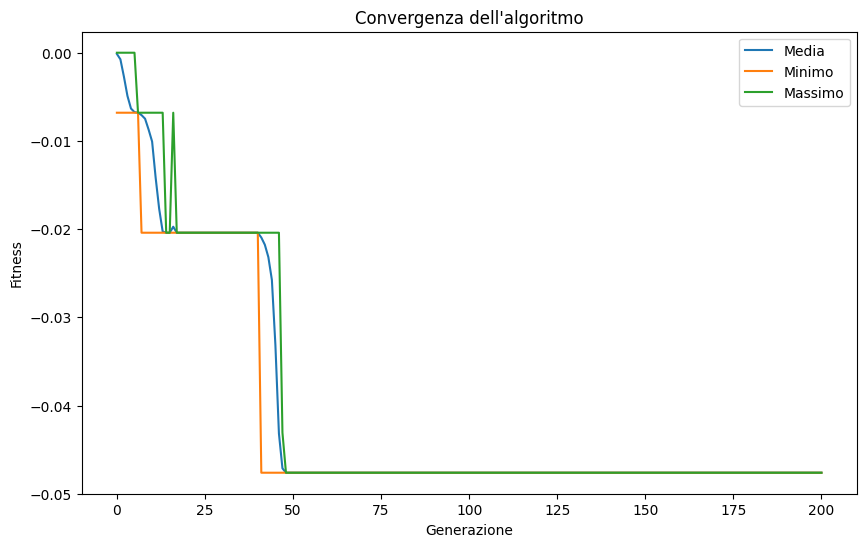

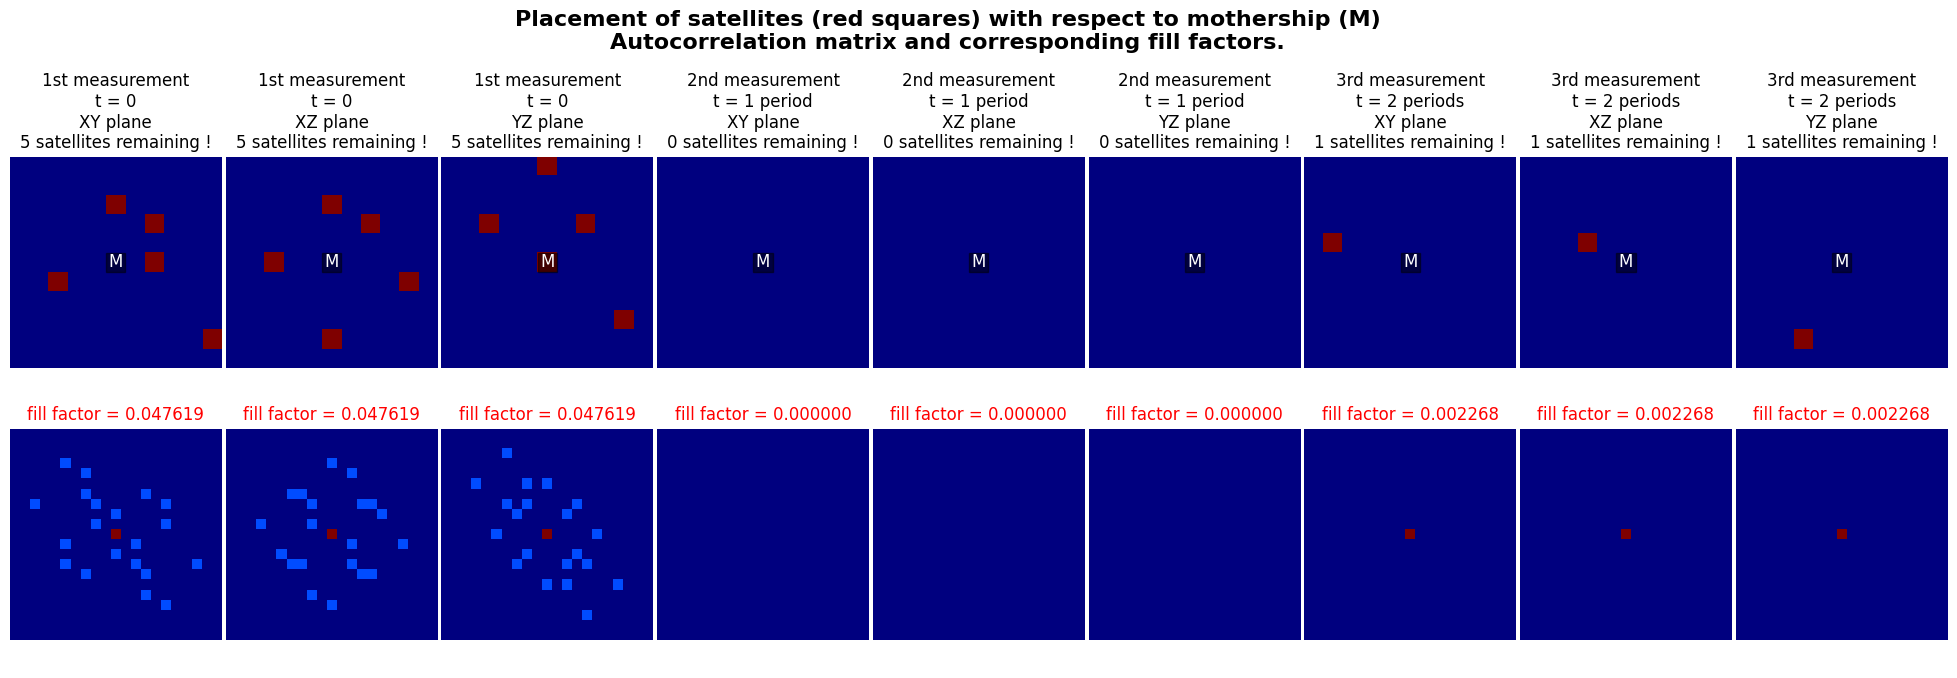

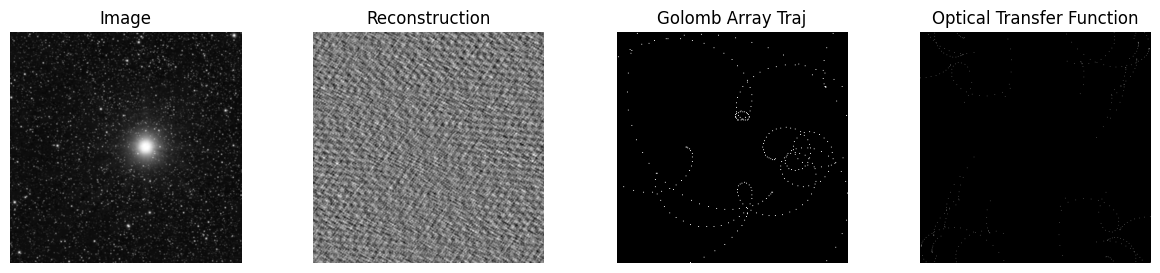

XZ


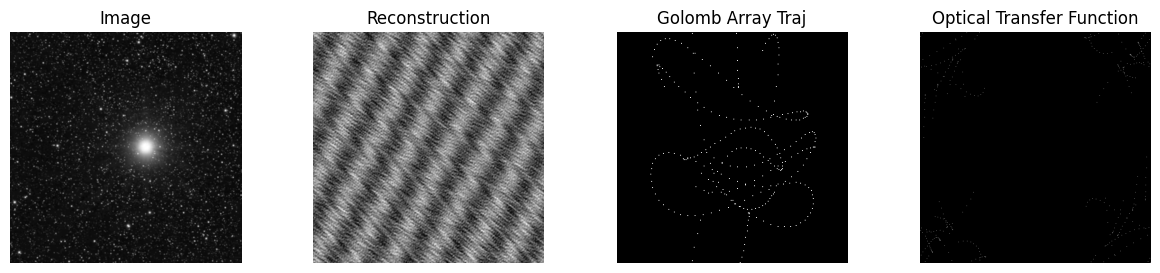

YZ


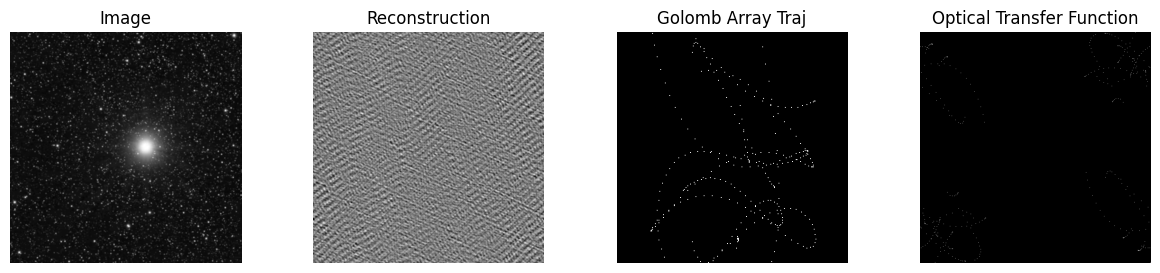

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from problems.golomb_simple import udp

# 1. Impostazione dei parametri di configurazione
POPULATION_SIZE = 100
GENERATIONS = 200
CXPB = 0.7
MUTPB = 0.1
INDIVIDUAL_SIZE = 30

# 2. Creazione dei tipi di fitness e individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Fitness da minimizzare
creator.create("Individual", list, fitness=creator.FitnessMin)

# 3. Creazione della toolbox
def create_toolbox():
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -1, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, INDIVIDUAL_SIZE)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    return toolbox

# Registrazione della funzione di valutazione
def evaluate(individual):
    return udp.fitness(individual), # La virgola è necessaria per restituire una tupla

# 5. Registrazione degli operatori
def register_operators(toolbox):
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

# 6. Impostazione della statistica
def set_statistics():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    return stats

# 7. Funzione principale dell'algoritmo
def run_algorithm(toolbox):
    pop = toolbox.population(n=POPULATION_SIZE)
    hof = tools.HallOfFame(1)  # Hall of Fame per il miglior individuo

    stats = set_statistics()

    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox,
                                             mu=POPULATION_SIZE,
                                             lambda_=POPULATION_SIZE,
                                             cxpb=CXPB,
                                             mutpb=MUTPB,
                                             ngen=GENERATIONS,
                                             stats=stats,
                                             halloffame=hof,
                                             verbose=True)
    return hof, logbook


def encode_satellites(n_satellites=5):
    # Definisci i limiti per le posizioni e le velocità
    pos_limits = (-1.0, 1.0)
    vel_limits = (-0.01, 0.01)
    
    # Genera posizioni e velocità casuali per ogni satellite
    satellites = []
    for _ in range(n_satellites):
        position = np.random.uniform(*pos_limits, size=3)
        velocity = np.random.uniform(*vel_limits, size=3)
        satellites.append(np.concatenate([position, velocity]))
    
    # Codifica in un'unica lista
    x_encoded = [dx[i] for i in range(6) for dx in satellites]
    return x_encoded

# 10. Esecuzione del programma
def main():
    toolbox = create_toolbox()
    register_operators(toolbox)
    
    hof, logbook = run_algorithm(toolbox)
    
    # Stampa i risultati
    print("Best individual found:")
    print(hof[0])
    print("Fitness:", hof[0].fitness.values)

    # Visualizzazione dei risultati
    print_result(logbook)
    #plot_best_solution(hof)

    # Codifica dei satelliti e plot
    x_encoded = encode_satellites()
    udp.plot(x_encoded, figsize=(25, 7))
    udp.plot_simulated_reconstruction(x_encoded, GENERATIONS, image_path="/home/mott/ESA_Interferometric_Mission/data/star.jpg")

# 11. Esecuzione del main
if __name__ == "__main__":
    main()


/home/mott/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mott/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std       	min     	max
0  	100   	0.999728	0.00133306	0.993197	1  
1  	79    	0.998912	0.00249392	0.993197	1  
2  	77    	0.997279	0.00333264	0.993197	1  
3  	89    	0.994762	0.00286281	0.993197	1  
4  	78    	0.993605	0.00161556	0.993197	1  
5  	80    	0.993333	0.000952381	0.993197	1  
6  	82    	0.993333	0.000952381	0.993197	1  
7  	80    	0.993197	0          	0.993197	0.993197
8  	88    	0.993061	0.00135372 	0.979592	0.993197
9  	80    	0.993061	0.00135372 	0.979592	0.993197
10 	77    	0.992789	0.00232091 	0.979592	0.993197
11 	85    	0.992313	0.00355503 	0.979592	1       
12 	84    	0.991701	0.004257   	0.979592	0.993197
13 	78    	0.989796	0.00589133 	0.979592	0.993197
14 	83    	0.987483	0.00671508 	0.979592	0.993197
15 	84    	0.983265	0.00604026 	0.979592	0.993197
16 	85    	0.980272	0.00296524 	0.979592	0.993197
17 	85    	0.979864	0.00190476 	0.979592	0.993197
18 	81    	0.979592	1.11022e-16	0.979592	0.979592
19 	79    	0.978776	0.00464183 	0.952381	0.979

INFO:root:Best individual found:
INFO:root:[0.13256223942468282, -0.34323203638594135, -0.4123109093417816, 0.7905788463915675, -0.07021712590669882, -0.3297700682497094, -0.012573710552135298, 0.43273010029692505, 0.1473027003917573, -0.17545212508510963, -0.5398988996751612, -0.45175839222023084, -0.18465281253121035, 0.3684048266142026, -0.6742574984312593, -0.8359572062438183, -0.5893331977216001, -0.64119404026613, -0.4706316809821213, -0.038847257728557905, 0.2718845603475823, -0.9463180511235838, 0.3209444991764838, -0.9478006946855848, -0.18345835588089554, 0.9778355597478232, 0.5107962848831129, -0.4884684860802735, -0.45627734150400917, -0.7058913005048335]
INFO:root:Fitness: (0.9523809523809523,)


200	82    	0.952381	1.11022e-16	0.952381	0.952381
XY


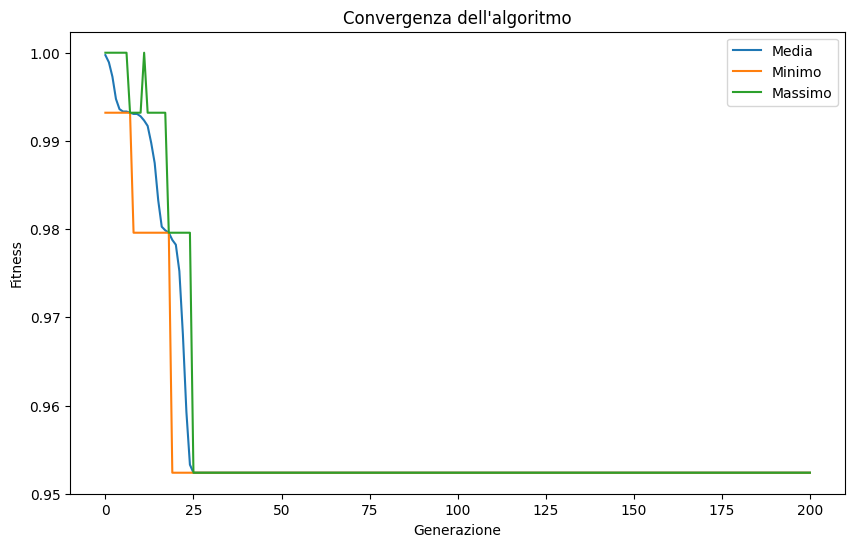

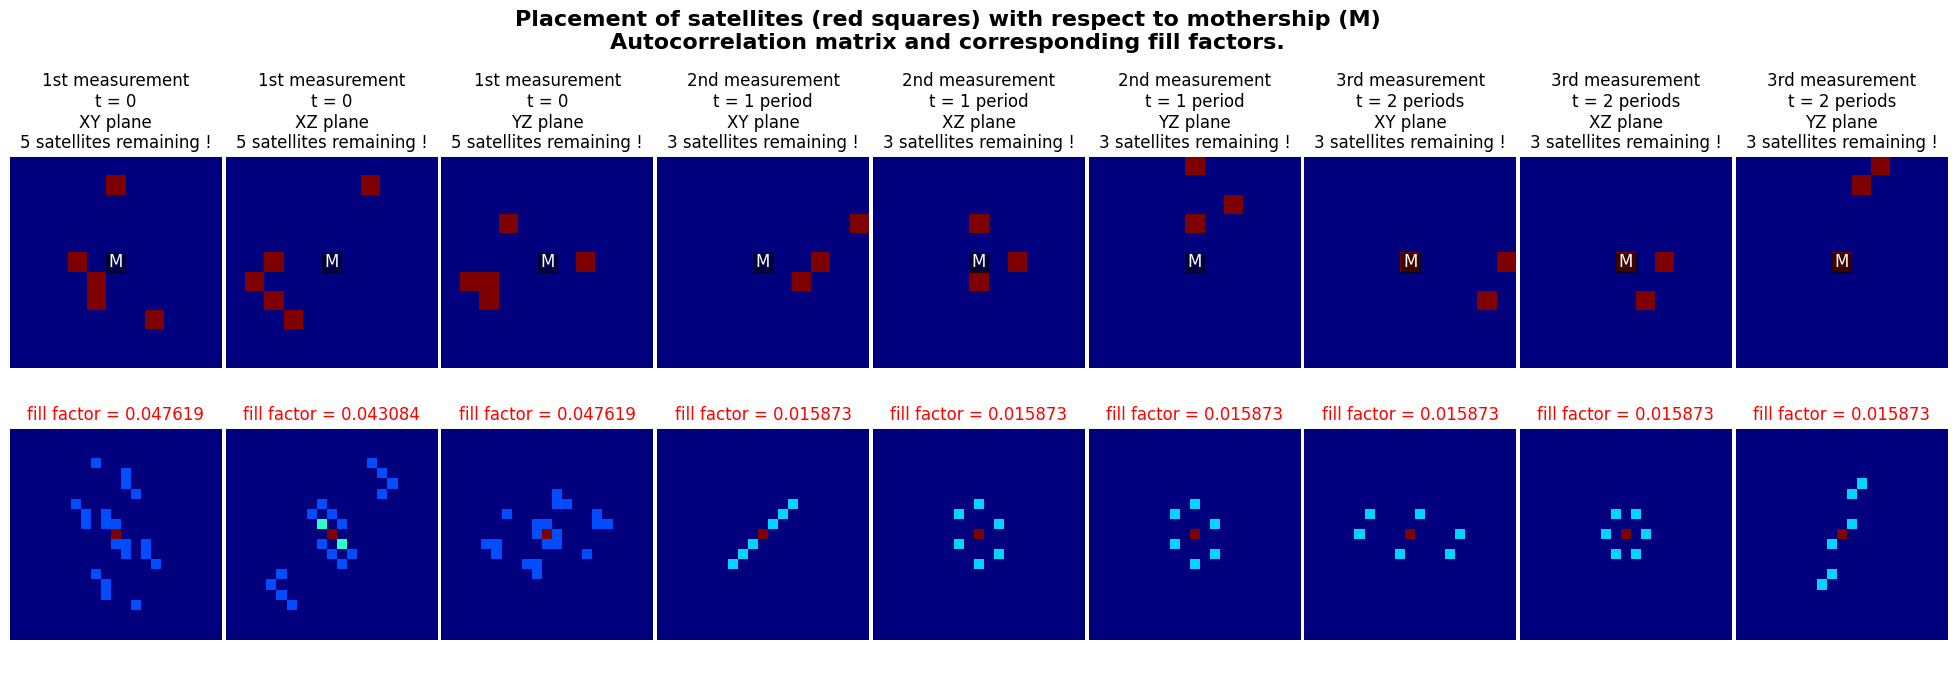

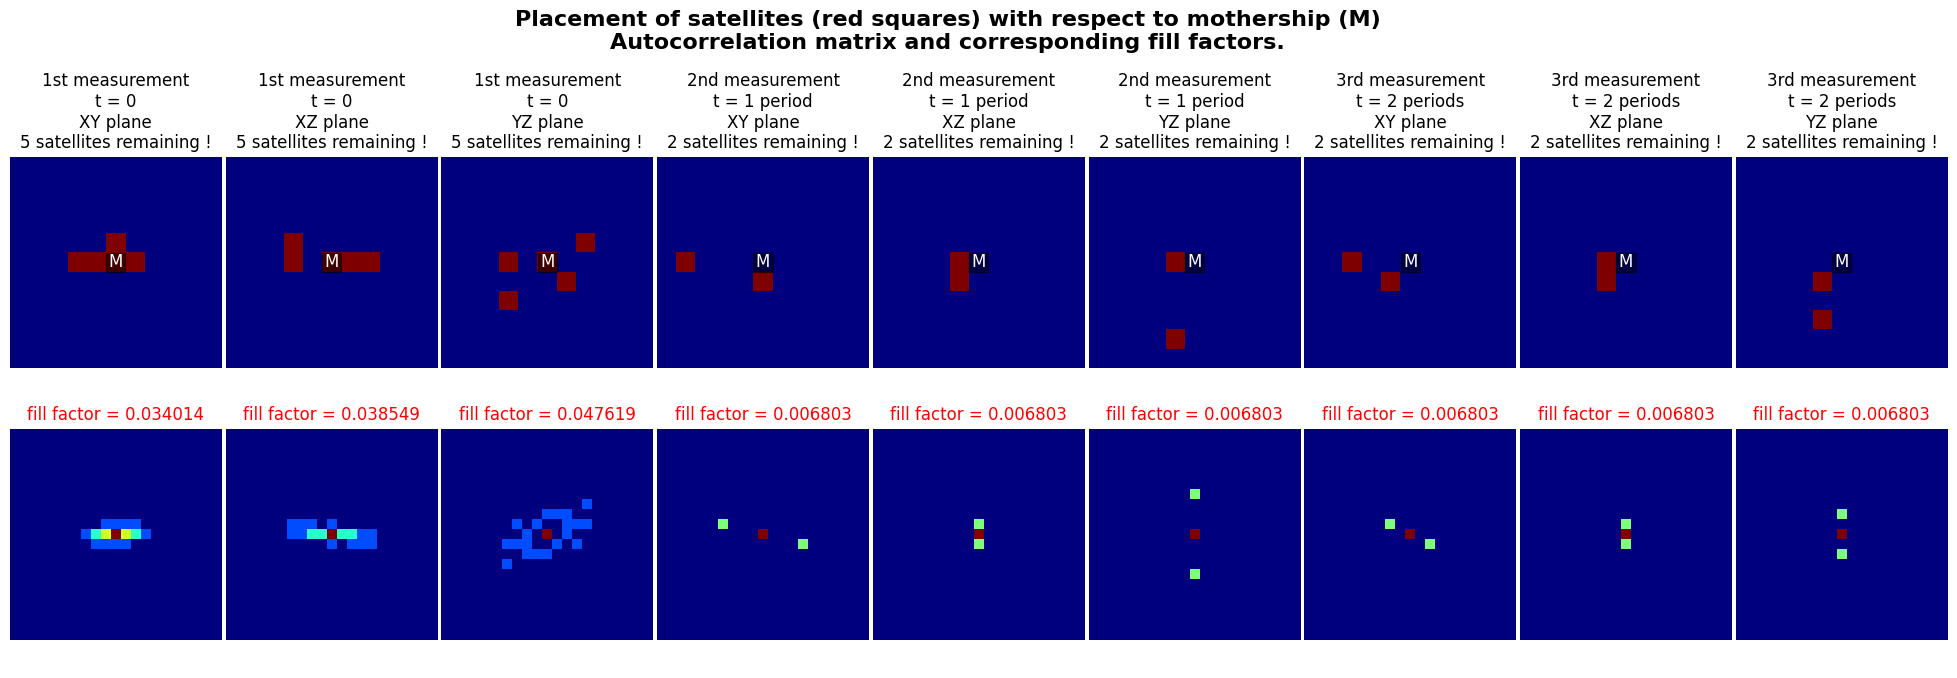

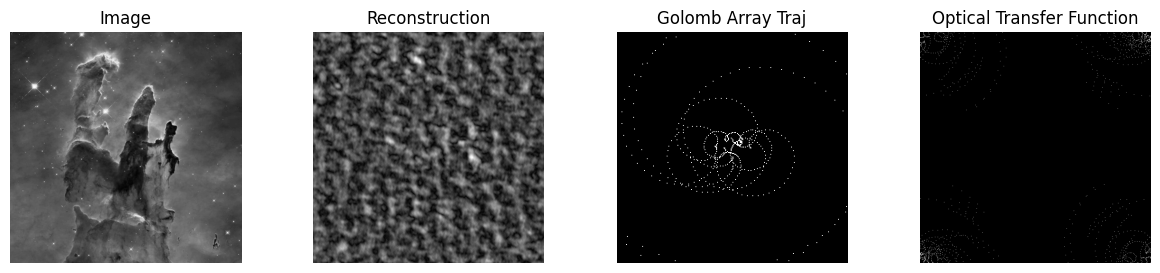

XZ


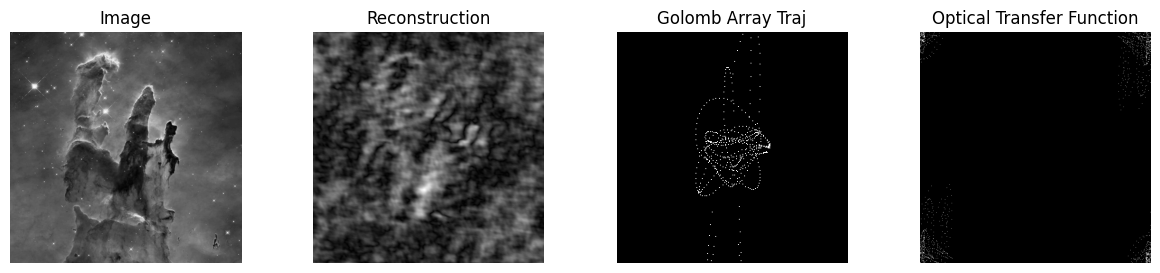

YZ


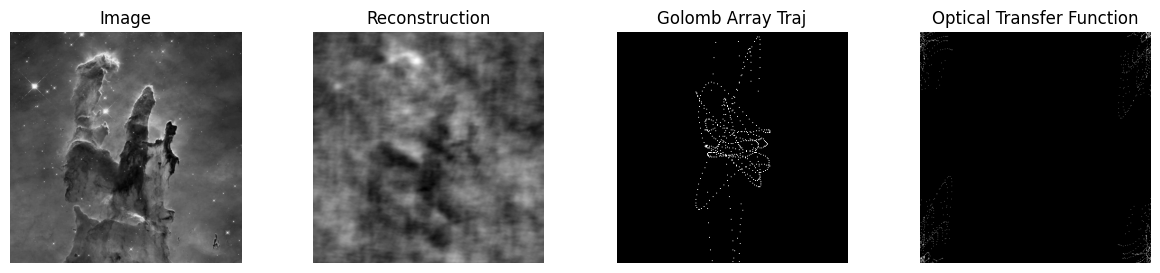

In [ ]:
import logging
# 1. Impostazione dei parametri di configurazione
POPULATION_SIZE = 100
GENERATIONS = 200
CXPB = 0.7
MUTPB = 0.1
INDIVIDUAL_SIZE = 30

# 2. Creazione dei tipi di fitness e individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Fitness da minimizzare
creator.create("Individual", list, fitness=creator.FitnessMin)



# 8. Visualizzazione dei risultati
def print_result(logbook):
    plt.figure(figsize=(10, 6))
    plt.plot(logbook.select("gen"), logbook.select("avg"))
    plt.plot(logbook.select("gen"), logbook.select("min"))
    plt.plot(logbook.select("gen"), logbook.select("max"))
    plt.xlabel("Generazione")
    plt.ylabel("Fitness")
    plt.title("Convergenza dell'algoritmo")
    plt.legend(["Media", "Minimo", "Massimo"])
    plt.savefig("convergence_plot.png")

def plot_best_solution(hof):
    udp.plot(hof[0], figsize=(25, 7))
    plt.savefig("best_solution_plot.png")

# 9. Codifica delle posizioni dei satelliti
def encode_satellites():
    satellite_1 = [0.1, 0.0, 0.1, -0.0042, -0.004, 0.0023]
    satellite_2 = [0.0, 0.2, 0.4, -0.0001, 0.001, 0.0003]
    satellite_3 = [0.0, -0.1, 0.3, 0.0201, 0.025, 0.0001]
    satellite_4 = [0.2, 0.0, -0.2, -0.0001, 0.003, -0.0100]
    satellite_5 = [0.1, -0.2, -0.3, 0.0000, 0.001, -0.0117]

    all_satellites = [satellite_1, satellite_2, satellite_3, satellite_4, satellite_5]
    
    # Codifica in un'unica lista
    x_encoded = np.array([dx[i] for i in range(6) for dx in all_satellites])  # Usa NumPy per operazioni più veloci
    return x_encoded

# 10. Esecuzione del programma
def main():
    logging.basicConfig(level=logging.INFO)  # Configura i log a livello INFO
    toolbox = create_toolbox()
    register_operators(toolbox)
    
    hof, logbook = run_algorithm(toolbox)
    
    # Log dei risultati
    logging.info("Best individual found:")
    logging.info(hof[0])
    logging.info("Fitness: %s", hof[0].fitness.values)

    # Visualizzazione dei risultati
    print_result(logbook)
    plot_best_solution(hof)

    # Codifica dei satelliti e plot
    x_encoded = encode_satellites()
    udp.plot(x_encoded, figsize=(25, 7))
    udp.plot_simulated_reconstruction(x_encoded, GENERATIONS, image_path="/home/mott/ESA_Interferometric_Mission/data/nebula.jpg")

# 11. Esecuzione del main
if __name__ == "__main__":
    main()


Generazione 1/50 completata.
Generazione 2/50 completata.
Generazione 3/50 completata.
Generazione 4/50 completata.
Generazione 5/50 completata.
Generazione 6/50 completata.
Generazione 7/50 completata.
Generazione 8/50 completata.
Generazione 9/50 completata.
Generazione 10/50 completata.
Generazione 11/50 completata.
Generazione 12/50 completata.
Generazione 13/50 completata.
Generazione 14/50 completata.
Generazione 15/50 completata.
Generazione 16/50 completata.
Generazione 17/50 completata.
Generazione 18/50 completata.
Generazione 19/50 completata.
Generazione 20/50 completata.
Generazione 21/50 completata.
Generazione 22/50 completata.
Generazione 23/50 completata.
Generazione 24/50 completata.
Generazione 25/50 completata.
Generazione 26/50 completata.
Generazione 27/50 completata.
Generazione 28/50 completata.
Generazione 29/50 completata.
Generazione 30/50 completata.
Generazione 31/50 completata.
Generazione 32/50 completata.
Generazione 33/50 completata.
Generazione 34/50 c

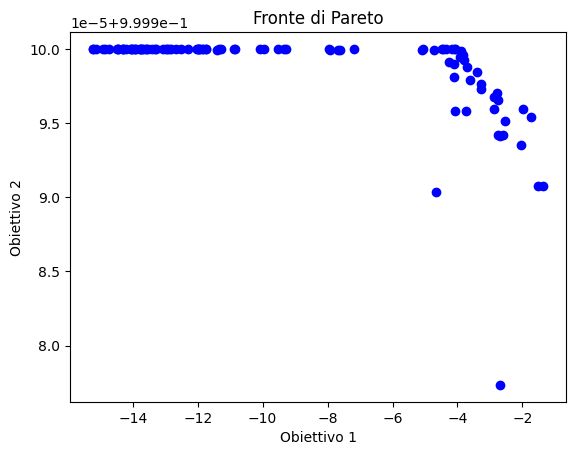

In [ ]:
import random

def evaluate(individual):
    # Esempio di funzione multi-obiettivo
    f1 = np.sum(individual)+1
    f2 = np.prod(individual)+1
    return f1, f2
# Generazione iniziale della popolazione
def generate_population(pop_size, n_var, lower_bound, upper_bound):
    return np.random.uniform(lower_bound, upper_bound, (pop_size, n_var))


# Dominance check (ind1 domina ind2?)
def dominates(ind1, ind2):
    return all(x <= y for x, y in zip(ind1, ind2)) and any(x < y for x, y in zip(ind1, ind2))


# Calcolo del ranking basato sulla dominanza
def non_dominated_sort(population):
    pop_size = len(population)
    domination_count = np.zeros(pop_size)
    dominated_solutions = [[] for _ in range(pop_size)]
    fronts = [[]]

    for p in range(pop_size):
        for q in range(pop_size):
            if dominates(population[p], population[q]):
                dominated_solutions[p].append(q)
            elif dominates(population[q], population[p]):
                domination_count[p] += 1

        if domination_count[p] == 0:
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in dominated_solutions[p]:
                domination_count[q] -= 1
                if domination_count[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    return fronts[:-1]


# Calcolo della crowding distance per un fronte
def crowding_distance(front, fitnesses):
    fitnesses_front = fitnesses[front]
    distances = np.zeros(len(front))

    for m in range(fitnesses_front.shape[1]):
        sorted_indices = np.argsort(fitnesses_front[:, m])
        sorted_fitnesses = fitnesses_front[sorted_indices]

        distances[sorted_indices[0]] = distances[sorted_indices[-1]] = float("inf")
        for i in range(1, len(sorted_indices) - 1):
            distances[sorted_indices[i]] += (
                sorted_fitnesses[i + 1, m] - sorted_fitnesses[i - 1, m]
            )
    return distances


def select_next_generation(population, fitnesses, n_select):
    fronts = non_dominated_sort(fitnesses)
    new_population = []

    for front in fronts:
        if len(new_population) + len(front) > n_select:
            distances = crowding_distance(np.array(front), fitnesses)
            sorted_front = sorted(
                zip(front, distances), key=lambda x: x[1], reverse=True
            )
            sorted_front = [x[0] for x in sorted_front]
            new_population.extend(sorted_front[: n_select - len(new_population)])
            break
        new_population.extend(front)

    return population[np.array(new_population)]



# Operatori di crossover
def crossover(parent1, parent2):
    alpha = random.uniform(0, 1)
    return alpha * parent1 + (1 - alpha) * parent2


# Operatori di mutazione
def mutate(individual, lower_bound, upper_bound, mutation_rate):
    for i in range(len(individual)):
        if random.uniform(0, 1) < mutation_rate:
            individual[i] += random.uniform(lower_bound, upper_bound)
    return np.clip(individual, lower_bound, upper_bound)


# NSGA-II
def nsga2(pop_size, n_var, lower_bound, upper_bound, generations, crossover_rate, mutation_rate):
    # Inizializzazione
    population = generate_population(pop_size, n_var, lower_bound, upper_bound)
    fitnesses = np.array([evaluate(ind) for ind in population])

    for gen in range(generations):
        # Creazione dei figli
        offspring = []
        for _ in range(pop_size):
            p1, p2 = random.sample(range(pop_size), 2)
            if random.uniform(0, 1) < crossover_rate:
                child = crossover(population[p1], population[p2])
                child = mutate(child, lower_bound, upper_bound, mutation_rate)
                offspring.append(child)
        offspring = np.array(offspring)

        # Fitness dei figli
        offspring_fitnesses = np.array([evaluate(ind) for ind in offspring])

        # Unione della popolazione e selezione della prossima generazione
        combined_population = np.vstack((population, offspring))
        combined_fitnesses = np.vstack((fitnesses, offspring_fitnesses))
        population = select_next_generation(combined_population, combined_fitnesses, pop_size)
        fitnesses = np.array([evaluate(ind) for ind in population])

        # Mostrare i progressi
        print(f"Generazione {gen + 1}/{generations} completata.")

    return population, fitnesses


# Parametri del problema
POP_SIZE = 100
N_VAR = 30  # Numero di variabili
LOWER_BOUND = -1
UPPER_BOUND = 1
GENERATIONS = 50
CROSSOVER_RATE = 0.9
MUTATION_RATE = 0.1

# Esecuzione
population, fitnesses = nsga2(
    POP_SIZE, N_VAR, LOWER_BOUND, UPPER_BOUND, GENERATIONS, CROSSOVER_RATE, MUTATION_RATE
)


# Assicurati di chiamare evaluate su ogni individuo per ottenere fitness multi-obiettivo
fitnesses = np.array([evaluate(ind) for ind in population])
print(f"Dimensioni fitness: {fitnesses.shape}")

# Plot solo se sono presenti almeno due obiettivi
if fitnesses.shape[1] > 1:
    f1 = fitnesses[:, 0]
    f2 = fitnesses[:, 1]
    plt.scatter(f1, f2, c="blue")
    plt.xlabel("Obiettivo 1")
    plt.ylabel("Obiettivo 2")
    plt.title("Fronte di Pareto")
    plt.show()
else:
    print("Il problema è configurato come a singolo obiettivo.")



INFO:root:Avvio dell'algoritmo genetico


gen	nevals	avg    	std       	min     	max
0  	100   	0.99966	0.00148262	0.993197	1  
1  	74    	0.999524	0.00173569	0.993197	1  
2  	73    	0.998912	0.00249392	0.993197	1  
3  	83    	0.998163	0.00344932	0.979592	1  
4  	79    	0.997211	0.00373778	0.979592	1  
5  	61    	0.996871	0.00339046	0.993197	1  
6  	68    	0.99585 	0.00331803	0.993197	1  
7  	74    	0.994898	0.00294566	0.993197	1  
8  	67    	0.994966	0.00298391	0.993197	1  
9  	65    	0.994762	0.00286281	0.993197	1  
10 	71    	0.994898	0.00294566	0.993197	1  
11 	64    	0.99483 	0.00290533	0.993197	1  
12 	71    	0.994422	0.00309953	0.979592	1  
13 	79    	0.994422	0.00261352	0.993197	1  
14 	76    	0.994218	0.00294566	0.979592	1  
15 	74    	0.993605	0.00438973	0.979592	1  
16 	63    	0.992653	0.00487523	0.979592	1  
17 	64    	0.989841	0.00671508	0.979592	1  
18 	69    	0.987664	0.00705737	0.979592	1  
19 	56    	0.983333	0.00618823	0.979592	1  
20 	66    	0.982381	0.0056175 	0.979592	1  
21 	79    	0.981655	0.00556453	0.9

INFO:root:Miglior individuo trovato:
INFO:root:[0.8667322180199887, -0.026961115310264905, 0.8861214372745903, 0.3872462230718421, -0.1436490650158424, 0.46866253471054997, 0.11819780117803536, 0.06586776672690564, -0.4650816684252552, 0.27510722743600513, 0.20976902306179523, 0.5083423519038863, 0.05294750963343886, 0.8697972825229812, -0.7061298751329155, -0.2606084095846277, -0.4678545883221086, -0.6743490546518855, 0.5476295170226733, 0.8367269373515229, 0.6825086283484529, -0.06681529837730679, -0.9692051067085392, 0.9822286539781211, -0.367649146189833, -0.12279497238891834, -0.49882139988522356, 0.6162102768004437, 0.9756294765428597, 0.5187408518069878]
INFO:root:Fitness: (0.9523809523809523,)


200	85    	0.955283	0.00885272 	0.952381	0.993197
XY


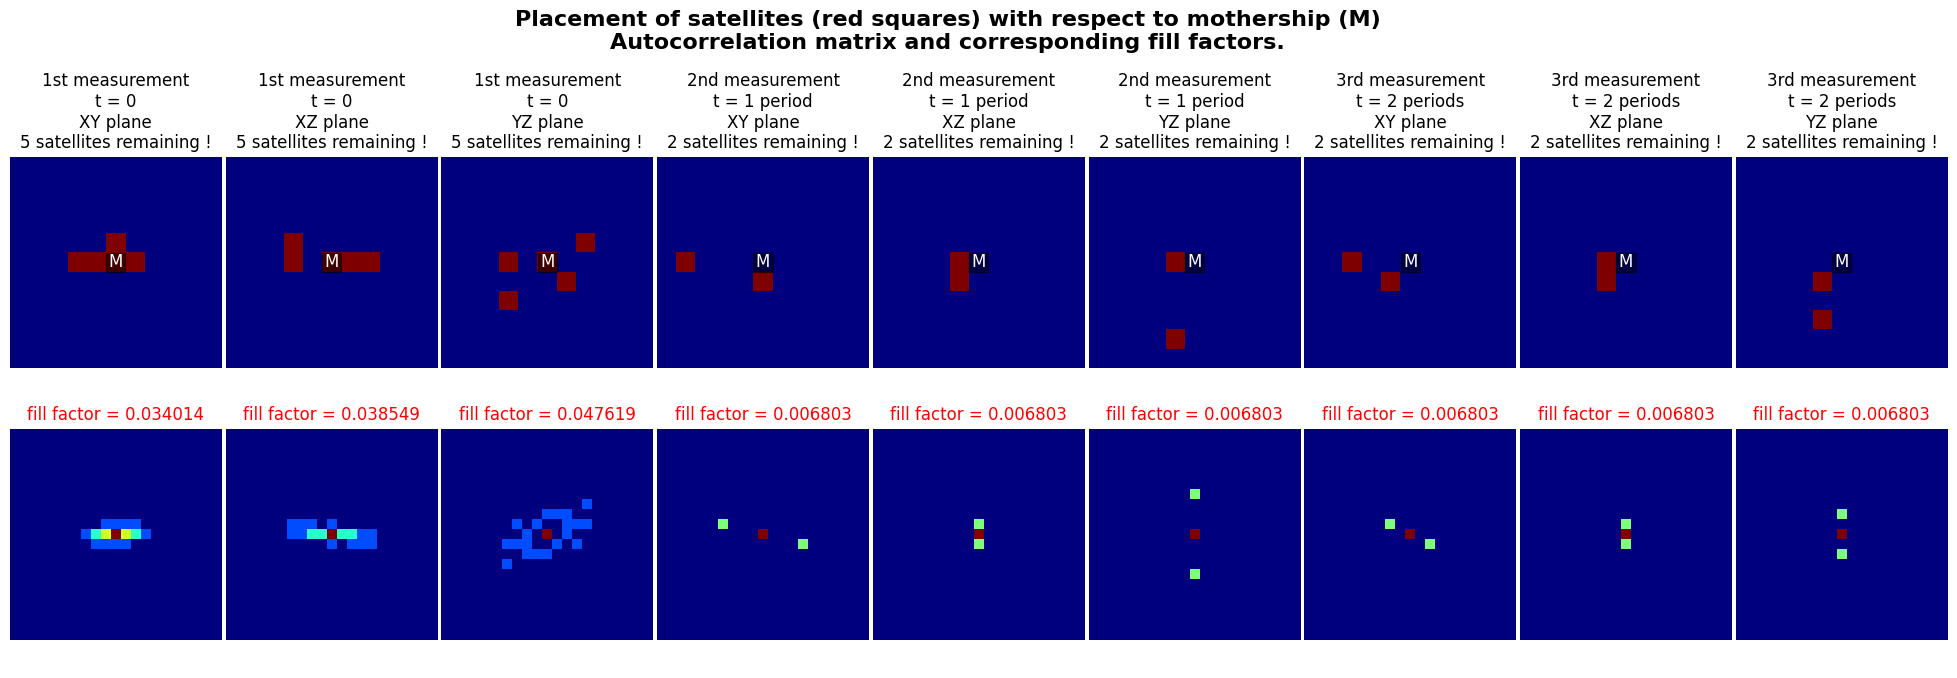

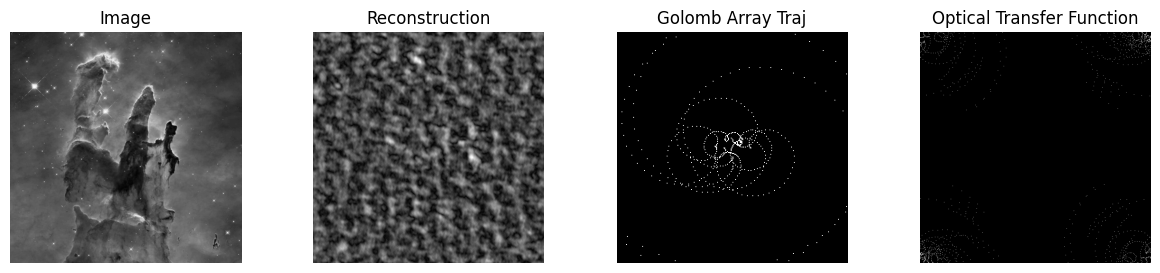

XZ


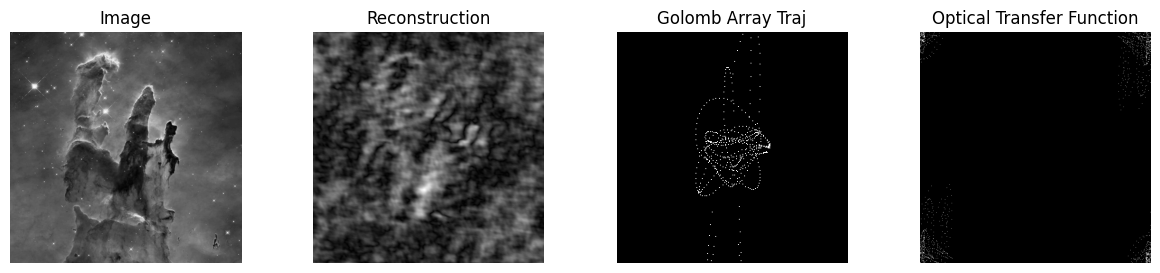

YZ


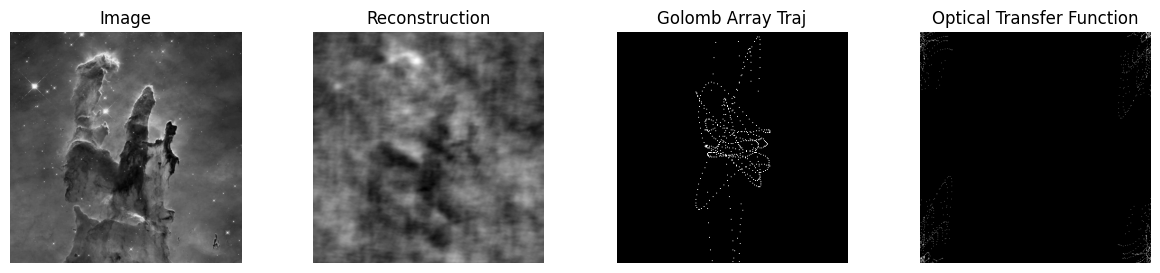

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator

# 1. Impostazioni dei parametri globali
POPULATION_SIZE = 100
GENERATIONS = 200
CXPB = 0.7
MUTPB = 0.1
INDIVIDUAL_SIZE = 30

# 2. Creazione dei tipi di fitness e individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 3. Toolbox e operatori
def create_toolbox():
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -1, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, INDIVIDUAL_SIZE)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    return toolbox

def register_operators(toolbox):
    toolbox.register("evaluate", evaluate_individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

# 4. Funzione di valutazione
def evaluate_individual(individual):
    return udp.fitness(individual)+1,

# 5. Algoritmo
def run_algorithm(toolbox):
    population = toolbox.population(n=POPULATION_SIZE)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, logbook = algorithms.eaSimple(
        population,
        toolbox,
        cxpb=CXPB,
        mutpb=MUTPB,
        ngen=GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True,
    )
    return hof, logbook

# 6. Visualizzazione dei risultati


def plot_best_solution(hof):
    udp.plot(hof[0], figsize=(25, 7))

# 7. Codifica parametrica dei satelliti
def encode_satellites(satellites):
    x_encoded = np.array([sat[i] for i in range(len(satellites[0])) for sat in satellites])
    return x_encoded

# 8. Esecuzione del programma
def main():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    toolbox = create_toolbox()
    register_operators(toolbox)
    
    logging.info("Avvio dell'algoritmo genetico")
    hof, logbook = run_algorithm(toolbox)
    
    # Log dei risultati
    logging.info("Miglior individuo trovato:")
    logging.info(hof[0])
    logging.info("Fitness: %s", hof[0].fitness.values)

    # Visualizzazione dei risultati
    #print_result(logbook)
    #plot_best_solution(hof)

    # Codifica e visualizzazione dei satelliti
    satellites = [
        [0.1, 0.0, 0.1, -0.0042, -0.004, 0.0023],
        [0.0, 0.2, 0.4, -0.0001, 0.001, 0.0003],
        [0.0, -0.1, 0.3, 0.0201, 0.025, 0.0001],
        [0.2, 0.0, -0.2, -0.0001, 0.003, -0.0100],
        [0.1, -0.2, -0.3, 0.0000, 0.001, -0.0117],
    ]

    x_encoded = encode_satellites(satellites)
    udp.plot(x_encoded, figsize=(25, 7))
    udp.plot_simulated_reconstruction(x_encoded, GENERATIONS, image_path="/home/mott/ESA_Interferometric_Mission/data/nebula.jpg")

# 9. Esecuzione
if __name__ == "__main__":
    main()
